In [1]:
%load_ext autoreload
%autoreload 2

from typing import *
from math import log2
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import theoretical_models as M

BLANK_PATCH = matplotlib.patches.Rectangle((0, 0), 0, 0, alpha=0)

matplotlib.rcParams.update({"legend.frameon": False, "axes.spines.right": False, "axes.spines.top": False})
# apt install texlive cm-super dvipng texlive-latex-extra
matplotlib.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": "CMU Serif"})

In [209]:
def tidy(*axs: matplotlib.axes.Axes) -> None:
    for ax in axs:
        NAME_MAP = dict(
            duration="Duration (s)",
            topk_size="$n$",
            j="$k_b$",
            k="$k$",
            k_mult="$b k_b / k$",
            cost_basic=r"$C^{\textrm{basic}}$",
            cost_serial=r"$C^{\textrm{serial}}$",
            cost_parallel=r"$C^{\textrm{parallel}}$",
        )
        def _get(name: str) -> str:
            return NAME_MAP.get(name, name)
        ax.set_xlabel(_get(ax.get_xlabel()))
        ax.set_ylabel(_get(ax.get_ylabel()))
        if ax.title is not None:
            ax.title.set_text(_get(ax.title.get_text()))

method_to_name = {
    'approx_topk.torch_default.topk': "torch",
    'approx_topk.bucket_argmax.topk_torch': "argmax",
    'approx_topk.priority_queue.topk': "queue",
}

df = (pd.concat([pd.read_json(f, lines=True) for f in Path("../data/generic2").glob("*.jsonl")])
    .reset_index(drop=True)
    .pipe(lambda d: d.assign(
        method=d.method.apply(method_to_name.__getitem__),
        duration=d.duration.apply(np.mean) / d.n_inner,
        duration_stderr=d.duration.apply(lambda d: np.std(d)/np.sqrt(len(d))) / d.n_inner,
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.dtype.apply(dict(float32=4, float16=2).__getitem__) * (d.topk_size + d.k) * d.batch_size / d.duration,
    ))
    .pipe(lambda d: d[(d.method != "argmax") | (d.compile == "default")])
    .drop(columns=["args", "compile", "cuda_graphs", "n_warmup", "n_outer", "n_inner", "n_inner_inputs", "dtype", "device"])
)
assert (df.groupby(["batch_size", "topk_size", "k", "j", "k_mult", "method"]).apply(len, include_groups=False) == 1).all()
print(len(df))
print(df.method.unique())
df.head()

2212
['queue' 'argmax' 'torch']


,batch_size,topk_size,k,j,k_mult,method,duration,duration_stderr,bandwidth
0,1,1024,1,1,1,queue,0.000005,6.133597e-09,3.838412e+08
1,1,1024,1,1,2,queue,0.000012,2.369724e-08,1.703896e+08
2,1,1024,1,1,4,queue,0.000012,2.812587e-08,1.725008e+08
3,1,1024,1,1,8,queue,0.000012,3.123933e-08,1.670282e+08
4,1,1024,1,1,16,queue,0.000012,3.084207e-08,1.694232e+08


In [3]:
print(f"Maximum stderr is {(df.duration_stderr / df.duration).max():.1%} of the mean")
print(f"Mean stderr is {(df.duration_stderr / df.duration).mean():.1%} of the mean")

Maximum stderr is 5.2% of the mean
Mean stderr is 0.1% of the mean


# Comparing cost models

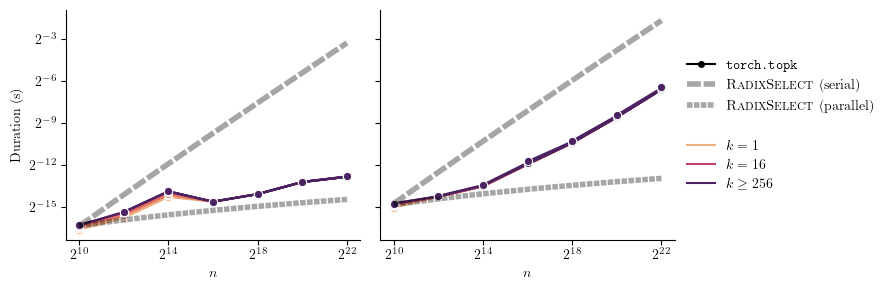

In [94]:
norm = matplotlib.colors.LogNorm(vmin=1, vmax=256)
palette = sns.color_palette("flare", as_cmap=True)
model_serial_args = dict(ls=(0, (2.5, 0.5)), lw=4, alpha=.35)
model_parallel_args = dict(ls=(0, (1, 0.25)), lw=4, alpha=.35)

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 3), sharey=True)
for batch_size, ax in zip([1, 256], axs):
    d = df[(df.batch_size==batch_size) & (df.method=="torch")]
    xs = d.topk_size.unique()
    sns.lineplot(data=d, y="duration", x="topk_size", hue="k", hue_norm=norm, markers=True, marker="o", palette=palette, ax=ax)
    s_upper, s_lower = (31.8, 24.8) if batch_size == 1 else (30.2, 23.3)
    ax.plot(xs, [M.cost_serial.radix(k=1, n=x, m=1)/2**s_upper for x in xs], "k", **model_serial_args, label=r"$\textsc{RadixSelect}$ (serial) rule")
    ax.plot(xs, [M.cost_parallel.radix(k=1, n=x, m=1)/2**s_lower for x in xs], "k", **model_parallel_args, label=r"$\textsc{RadixSelect}$ (parallel) rule")
    ax.legend_.remove()
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xticks([2**n for n in range(10, 22+1, 4)])
    tidy(ax)

handles, labels = [], []
handles.append(matplotlib.lines.Line2D([], [], color="k", marker="o", ms=4)); labels.append(r"\texttt{torch.topk}")
handles.append(matplotlib.lines.Line2D([], [], color="k", **model_serial_args)); labels.append(r"$\textsc{RadixSelect}$ (serial)")
handles.append(matplotlib.lines.Line2D([], [], color="k", **model_parallel_args)); labels.append(r"$\textsc{RadixSelect}$ (parallel)")
handles.append(BLANK_PATCH); labels.append("")
for k in [1, 16, 256]:
    handles.append(matplotlib.lines.Line2D([], [], color=palette(norm(k))))
    labels.append(f"$k={k}$")
labels[-1] = f"$k\ge{k}$"
axs[-1].legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()

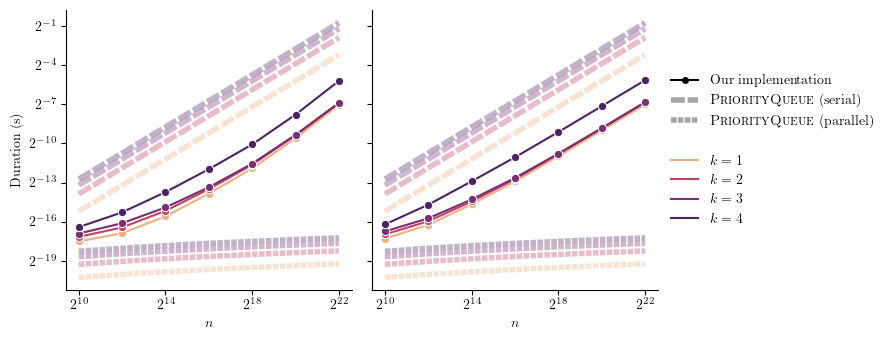

In [100]:
norm = matplotlib.colors.LogNorm(vmin=1, vmax=4)
palette = sns.color_palette("flare", as_cmap=True)
model_serial_args = dict(ls=(0, (2.5, 0.5)), lw=4, alpha=.35)
model_parallel_args = dict(ls=(0, (1, 0.25)), lw=4, alpha=.35)

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 3.5), sharey=True)
for batch_size, ax in zip([1, 256], axs):
    sns.lineplot(data=df[(df.k == df.j) & (df.k_mult == 1) & (df.method == "queue") & (df.batch_size == batch_size)],
                 y="duration", x="topk_size", hue="k", hue_norm=norm, palette=palette, markers=True, marker="o", ax=ax)
    for k in [1, 2, 3, 4]:
        ax.plot(xs, [M.cost_serial.insertion(k=k, n=x, m=1)/2**26.2 for x in xs], color=palette(norm(k)), **model_serial_args)
        ax.plot(xs, [M.cost_parallel.scan(k=k, n=x, m=1)/2**24.8 for x in xs], color=palette(norm(k)), **model_parallel_args)
    ax.legend_.remove()
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xticks([2**n for n in range(10, 22+1, 4)])
    tidy(ax)

handles, labels = [], []
handles.append(matplotlib.lines.Line2D([], [], color="k", marker="o", ms=4)); labels.append(r"Our implementation")
handles.append(matplotlib.lines.Line2D([], [], color="k", **model_serial_args)); labels.append(r"$\textsc{PriorityQueue}$ (serial)")
handles.append(matplotlib.lines.Line2D([], [], color="k", **model_parallel_args)); labels.append(r"$\textsc{PriorityQueue}$ (parallel)")
handles.append(BLANK_PATCH); labels.append("")
for k in [1, 2, 3, 4]:
    handles.append(matplotlib.lines.Line2D([], [], color=palette(norm(k)))); labels.append(f"$k={k}$")
axs[-1].legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()

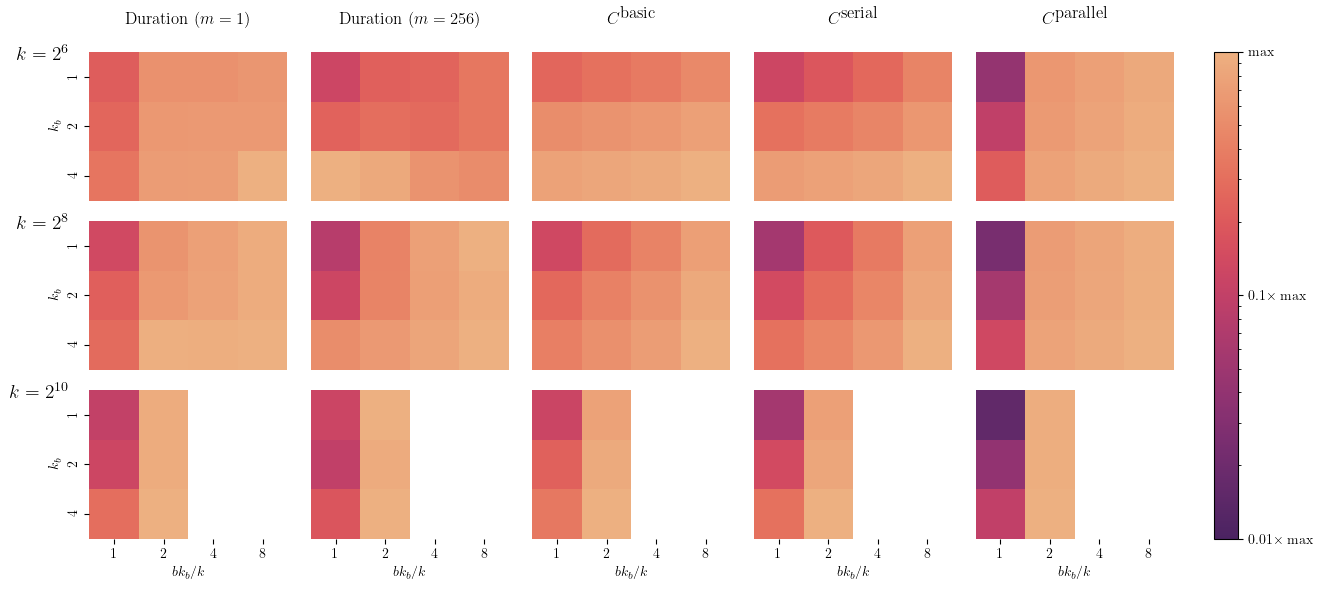

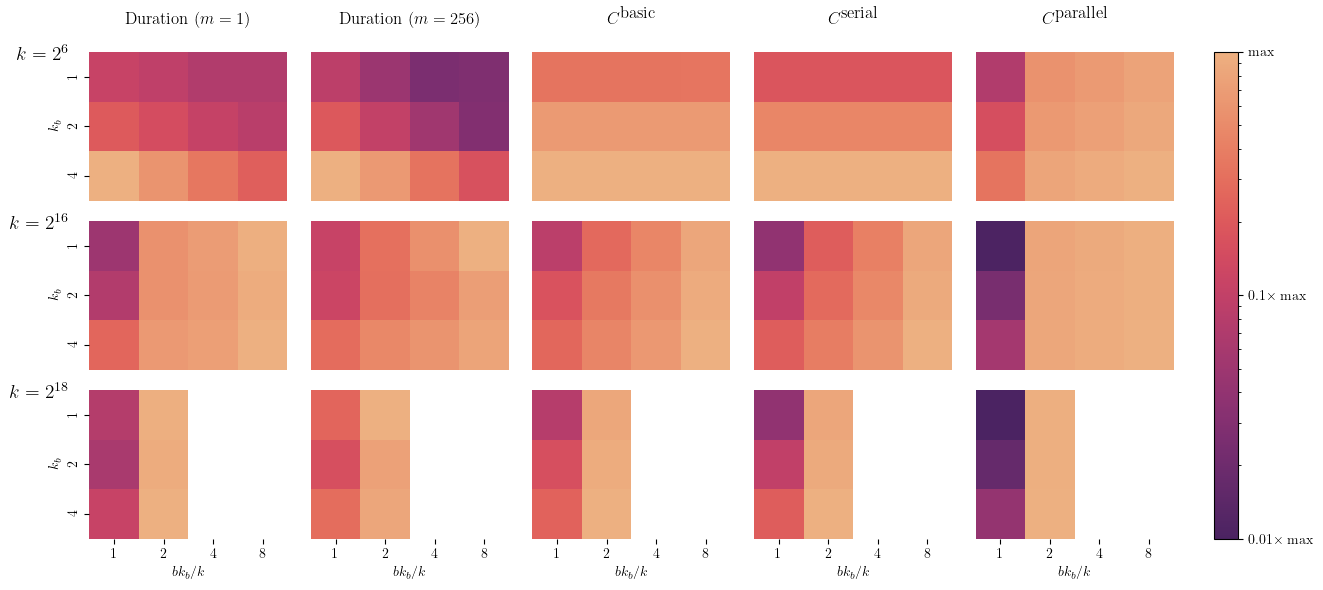

In [270]:
for topk_size in [2**12, 2**20]:
    k_mults = [1, 2, 4, 8]
    cols = ["duration_m1", "duration_m256", "cost_basic", "cost_serial", "cost_parallel"]
    ks = [64, topk_size//16, topk_size//4]

    d = (df[(df.method == "queue") & (df.k_mult.isin(k_mults)) & (df.topk_size == topk_size)]
        .pipe(lambda d: d.pivot(index=["topk_size", "k", "j", "k_mult"], columns="batch_size", values="duration").rename(columns={1: "duration_m1", 256: "duration_m256"}).reset_index())
        .pipe(lambda d: d.assign(**{
            model.__name__:
                d.apply(lambda s: model.approx_topk(n=s.topk_size, k=s.k, m=1, k_b=s.j, b=(s.k*s.k_mult)//s.j), axis=1)
            for model in M.COST_MODELS}))
    )

    fig, axs = plt.subplots(ncols=len(cols), nrows=len(ks), figsize=(len(cols)*2.5 + 2, len(ks)*2), sharey=True, squeeze=False)

    for k, axr in zip(ks, axs):
        for cost, ax in zip(cols, axr):
            g = d[d.k == k]
            grid = g.pivot(index="j", columns="k_mult", values=cost)
            for k_mult in k_mults:
                if k_mult not in grid.columns:
                    grid[k_mult] = float("nan")
            sns.heatmap(grid, norm=matplotlib.colors.LogNorm(g[cost].max()/100, g[cost].max()),
                        cmap="flare_r", cbar=False, square=True, ax=ax)
            if axr[0] is axs[0, 0]:
                ax.set_title({"duration_m1": "Duration ($m=1$)", "duration_m256": "Duration ($m=256$)"}.get(cost, cost), pad=20)
            if axr[0] is not axs[-1, 0]:
                ax.set_xlabel("")
                ax.set_xticks([])
            if ax is axr[0]:
                ax.text(-0.1, 1.04, f"$k=2^{{{log2(k):.0f}}}$", va="top", ha="right", transform=ax.transAxes, fontsize=14)
            if ax is not axr[0]:
                ax.set_ylabel("")
                ax.tick_params(left=False)
            tidy(ax)
    plt.tight_layout()
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1/100, 1), cmap="flare_r"), ax=axs, shrink=1, pad=0.03)
    cbar.set_ticks([1/100, 1/10, 1])
    cbar.set_ticklabels(["max" if x == 1 else f"${x}\\!\\times \\mathrm{{max}}$" for x in cbar.get_ticks()])